In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import ta
from ta import add_all_ta_features
from ta.utils import dropna
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import itertools
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

nasdaq_tickers = ['TMUSR', 'AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'INTC', 'NVDA', 'ADBE',
               'PYPL', 'CSCO', 'NFLX', 'PEP', 'TSLA', 'CMCSA', 'AMGN', 'COST', 'TMUS', 'AVGO',
               'TXN', 'CHTR', 'QCOM', 'GILD', 'SBUX', 'INTU', 'VRTX', 'MDLZ', 'ISRG', 'FISV',
               'BKNG', 'ADP', '', 'ATVI', 'AMD', 'JD', 'MU', 'AMAT', 'ILMN', 'ADSK',
               'CSX', 'MELI', 'LRCX', 'ADI', 'ZM', 'BIIB', 'EA', 'KHC', 'WBA', 'LULU',
               'EBAY', 'MNST', 'DXCM', 'EXC', 'BIDU', 'XEL', 'WDAY', 'DOCU', 'SPLK', 'ORLY',
               'NXPI', 'CTSH', 'KLAC', 'SNPS', 'SGEN', 'ASML', 'IDXX', 'CSGP', 'CTAS', 'VRSK',
               'MAR', 'CDNS', 'PAYX', 'ALXN', 'MCHP', 'SIRI', 'ANSS', 'VRSN', 'FAST', 'BMRN',
               'XLNX', 'INCY','DLTR', 'SWKS', 'ALGN', 'CERN', 'CPRT', 'CTXS', 'TTWO', 'MXIM',
               'CDW', 'CHKP', 'WDC', 'ULTA', 'NTAP', 'FOXA', 'LBTYK']

In [3]:
data = yf.Ticker('ALMIL.PA').history(period='5y').drop(columns=['Dividends','Stock Splits'])
data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume").iloc[51:,:]
data.tail()

C:\Users\remik\AppData\Roaming\Python\Python38\site-packages\ta\trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\remik\AppData\Roaming\Python\Python38\site-packages\ta\trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Open       High  ...  others_dlr  others_cr
Date                                             ...                       
2022-11-21 00:00:00+01:00  28.200001  28.200001  ...   -1.428601  -30.50702
2022-11-22 00:00:00+01:00  27.799999  27.799999  ...    0.000000  -30.50702
2022-11-23 00:00:00+01:00  27.799999  27.799999  ...    0.000000  -30.50702
2022-11-24 00:00:00+01:00  27.799999  27.799999  ...    0.000000  -30.50702
2022-11-25 00:00:00+01:00  27.799999  27.799999  ...    0.000000  -30.50702

[5 rows x 91 columns]

In [4]:
def garch_relevant_parameters(stock_data, alpha_max = .35):
    aic = []
    max_alpha = alpha_max
    scaled_returns = data['Close'].pct_change().dropna()*100
    params = [1, 0]
    model = arch_model(scaled_returns, p=params[0], q=params[1], dist='t').fit(disp='off')
    max_pval = np.max(model.pvalues[1:])
    aic.append(params + [model.aic, model.bic, model.loglikelihood,  model.pvalues[1:].mean()])
    if max_pval > max_alpha :
        print('GARCH process is not available for this stock')
        return None
    else :
        #searching for maximum significant coefficient with p
        while max_pval < max_alpha :
            params[0] += 1
            model = arch_model(scaled_returns, p=params[0], q=params[1], dist='t').fit(disp='off')
            max_pval = np.max(model.pvalues[1:])

        #for p in [1, ..., max_p-1], search for q until it is unsignificant
        for i in range(1,params[0]):
            params[0], params[1] = i, 0
            max_pval = np.max(arch_model(scaled_returns, p=params[0], q=params[1]).fit(disp='off').pvalues[1:])
            while max_pval < max_alpha :
                model = arch_model(scaled_returns, p=params[0], q=params[1], dist='t').fit(disp='off')
                max_pval = np.max(model.pvalues[1:])    
                aic.append(params + [model.aic, model.bic, model.loglikelihood, model.pvalues[1:].mean()])
                params[1] += 1
            aic = aic[:-1]
        return pd.DataFrame(list(aic for aic,_ in itertools.groupby(aic)), columns = ['p','q','aic','bic','log','pval.mean'])

def best_garch_model(stock_data):
    scaler = MinMaxScaler()
    significants_params = garch_relevant_parameters(data)
    if significants_params is None:
        return None
    else :
        metrics = significants_params.iloc[:,2:-1]
        scaler.fit(metrics)
        scaled_metrics = scaler.transform(metrics)
        significants_params['custom score'] = pd.Series([x.sum() for x in scaled_metrics])
        optimal_params = significants_params.sort_values(by=['custom score']).iloc[0,0:2]
        return optimal_params.astype(int).values
    
#student T garch
def historical_garch_signal(stock_data, params):
    scaled_returns = stock_data['Close'].pct_change().dropna()*100
    optimal_model = arch_model(scaled_returns, p=int(params[0]), q=int(params[1]), dist='t').fit(disp='off')
    rolling_predictions = []
    test_size = 365   
    for i in tqdm(range(test_size)):
        train = scaled_returns[:-(test_size-i)]
        model = arch_model(train, p=1, q=1, dist='t').fit(disp='off')
        pred = model.forecast(horizon=1,reindex=True)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    return rolling_predictions

In [5]:
#https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html
#res.conditional_volatility
import scipy
def rho_cal(X):
    rho_hat =  scipy.stats.pearsonr(X-np.mean(X), np.sign(X-  np.mean(X)))#rho_hat[0]:Pearson correlation , rho_hat[1]:two-tailed p-value
    return rho_hat[0]

def DD_volatility(y,lookback,alpha): #y = squared returns
    t = len(y)
    rho = rho_cal(y) # calcul de la correlation entre les log returns centrés et les signes des log return centrés
    vol = abs(y-np.mean(y))/rho # volatilité observée chaque jour
    MSE_alpha = np.zeros(len(alpha)) #initialisation du stockage des MSE pour chaque alpha
    sn = np.zeros(len(alpha))#initialisation du stockage de la volatilité pour chaque alpha
    historicals = []
    for a in range(len(alpha)):
        s =  np.mean(vol[0:lookback]) # calcul de la volalitilité moyenne a partir des n_cut_t premieres volatilités
        error = np.zeros(t)
        historical = []
        for i in range(t):
            error[i] = vol[i] - s #erreurs entre la volatilité estimée avec rho et reelle à chaque période (1 fois ^par jour)
            s = alpha[a]*vol[i]+(1-alpha[a])*s #volatilité n+1 estimée par EWMA
            historical.append(s)
        historicals.append(historical)
        MSE_alpha[a] = np.mean((error[(len(error)-lookback):(len(error))])**2) # mesure de l'erreur moyenne avec le FESS pour chaque alpha
        sn[a] = s #volatilité prédite (chaque jour car range(t)) stockée pour chaque alpha
    min_fss_pos = np.argmin(MSE_alpha)
    vol_forecast = sn[min_fss_pos] #which min
    optimal_alpha = alpha[min_fss_pos]
    RMSE = np.sqrt(min(MSE_alpha))
    
    plt.plot(vol.values[:])
    plt.plot([0] + historicals[min_fss_pos][:])
    return RMSE, optimal_alpha
    #return vol_forecast, RMSE, optimal_alpha, historicals[min_fss_pos] #, np.argmin()

In [6]:
def custom_volatility(y,l,alpha,plot_last): #y = squared returns
    #mettre une condition si
    t = len(y)
    rho = rho_cal(y) # calcul de la correlation entre les log returns centrés et les signes des log return centrés
    vol = abs(y-np.mean(y))/rho # volatilité observée chaque jour
    MSE_alpha = np.zeros(len(alpha)) #initialisation du stockage des MSE pour chaque alpha
    sn = np.zeros(len(alpha))#initialisation du stockage de la volatilité pour chaque alpha
    historicals = []
    for a in range(len(alpha)):
        spred =  np.mean(vol[0:l]) # calcul de la volalitilité moyenne a partir des n_cut_t premieres volatilités
        error = np.zeros(t-l)
        historical = []
        historical.append(spred)
        for i in range(t-l):
            error[i] = vol[i+l] - spred #erreurs entre la volatilité estimée avec rho et reelle à chaque période (1 fois ^par jour)
            spred = alpha[a]*vol[i+l-1]+(1-alpha[a])*spred
            historical.append(spred)
        spred = alpha[a]*vol[i+l]+(1-alpha[a])*spred
        historical.append(spred)
        historicals.append(historical)
        MSE_alpha[a] = np.mean(error**2) # mesure de l'erreur moyenne avec le FESS pour chaque alpha
        sn[a] = spred #volatilité prédite (chaque jour car range(t)) stockée pour chaque alpha
    min_fss_pos = np.argmin(MSE_alpha)
    vol_forecast = sn[min_fss_pos] #which min
    optimal_alpha = alpha[min_fss_pos]
    RMSE = np.sqrt(min(MSE_alpha))
    
    predictions = historicals[min_fss_pos]
    observed_volatility = vol.values
    #print(len(predictions),len(observed_volatility[l:]))
    plt.plot(observed_volatility[t-plot_last:])
    plt.plot(predictions[t-plot_last-l:])
    return RMSE, optimal_alpha

#scaler les returns

(0.043455837668007195, 0.8)

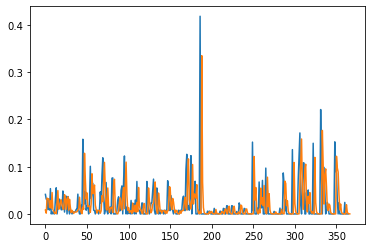

In [7]:
#toujours les memes valeurs on dirait
#jsp
y = np.log(data['Close']).diff().dropna()
custom_volatility(y,30,np.linspace(0.8,0.8,num=2),365)

(0.03540015363041717, 0.7677171717171717)

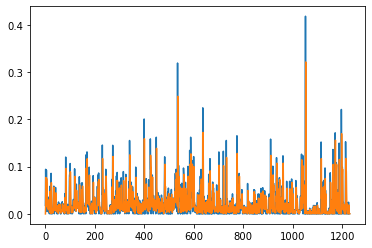

In [21]:
# probleme dans le stockage du s je pense comprend pas pq on a une valeur a chaque instant
y = np.log(data['Close']).diff().dropna()
DD_volatility(y,30,np.linspace(0.001,0.8,num=100))

(0.0340493016967972, 0.01714141414141414)

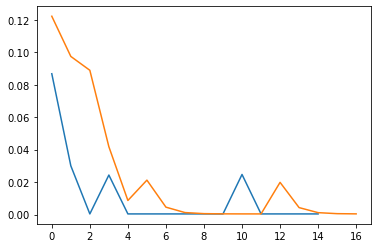

In [24]:
custom_volatility(y,10,np.linspace(0.001,0.8,num=100),15)

(0.03557578931987003, 0.01714141414141414)

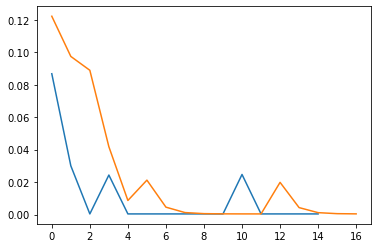

In [25]:
custom_volatility(y,250,np.linspace(0.001,0.8,num=100),15)

 16%|█▋        | 8/49 [00:08<00:45,  1.12s/it]


KeyboardInterrupt: 

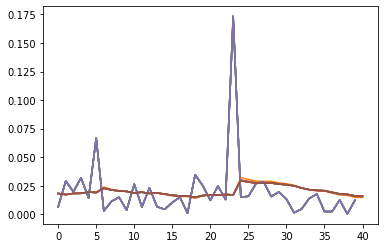

In [17]:
RMSE = []
alpha = []
tests = [x*2 for x in range(1,50)]
for i in tqdm(tests):
    r,a = custom_volatility(y,i,np.linspace(0.01,0.7,num=150),40)
    RMSE.append(r)
    alpha.append(a)

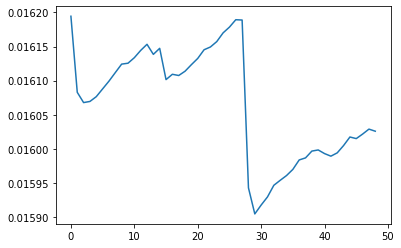

In [12]:
plt.plot(RMSE)

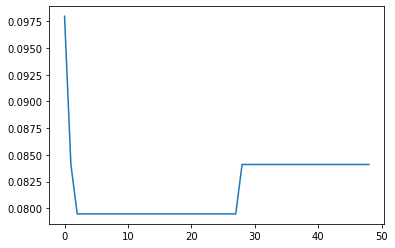

In [13]:
plt.plot(alpha)

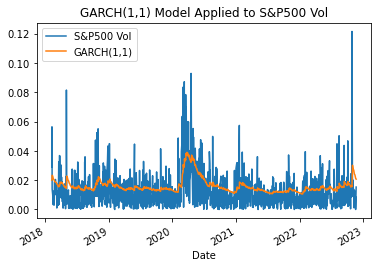

In [209]:
y_scaled = np.log(data['Close']).diff().dropna()*100
am = arch_model(y_scaled, p=1, q=1) #GARCH MODEL p=1 , q=1 #dist t moins bien
res = am.fit(update_freq=5, disp='off')
df = pd.DataFrame({'S&P500 Vol':np.abs(y),'GARCH(1,1)':res.conditional_volatility/100})
subplot = df.plot(title = 'GARCH(1,1) Model Applied to S&P500 Vol')

In [46]:
garch_relevant_parameters(data)

p  q          aic          bic          log  pval.mean
0  1  0  4590.126591  4610.510164 -2291.063295   0.000005
1  1  1  4539.364202  4564.843668 -2264.682101   0.050625
2  1  2  4540.319276  4570.894636 -2264.159638   0.086509
3  2  0  4572.777061  4598.256527 -2281.388530   0.001626
4  3  0  4562.038813  4592.614173 -2275.019407   0.010541
5  4  0  4556.845639  4592.516891 -2271.422819   0.057498

In [39]:
optimal_params = best_garch_model(data)
optimal_params

array([1, 1])

In [14]:
past_365_data = historical_garch_signal(data, optimal_params)

100%|██████████| 365/365 [00:15<00:00, 23.60it/s]


In [ ]:
#determiner
#rolling beta sur plusieurs unités de temps dynamic beta
#https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/
https://github.com/Taaniya/Stock-Price-Returns-Prediction/blob/master/Prediction_AXISBANK.ipynb

In [ ]:
#https://pub.towardsai.net/statistical-forecasting-for-time-series-data-part-5-arma-garch-model-for-time-series-forecasting-98beeedcfba8
#https://github.com/yashveersinghsohi/Statistical_Modeling_for_Time_Series_Forecasting/tree/master/Returns%20Models
#https://pub.towardsai.net/statistical-forecasting-for-time-series-data-part-6-forecasting-non-stationary-time-series-using-9acc28c39db9
#https://stackoverflow.com/questions/55882111/arima-model-for-certain-lags
#garch sur residuals de l'arima
#tester oubli de certains lags et ajout optimisation des parametres
#https://ionides.github.io/531w18/midterm_project/project38/Midterm_proj.html

Original P value: 0.8127248880651319
Differenced p value: 7.279059352322347e-20


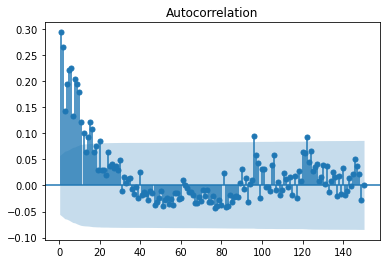

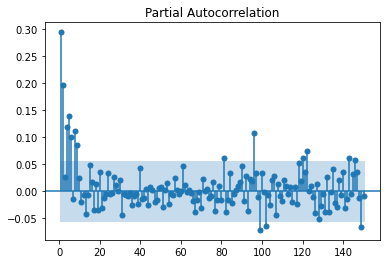

In [10]:
#stationnaire => pas de saisonnalité, aléatoire mais de moyenne constante, ne dépend pas du temps
#test de stationnarité : si la série est non stationnaire => elle possede une tendance et saisonnalité, et dépend du temps (p>0.05)

AdfResult1 = adfuller(data['Close'])
print ("Original P value:",AdfResult1[1]) 

#donc la série est non stationnaire et on doit la différencier pour utiiser arima
data['log_diff_data'] = np.log(data['Close'].values)
data['log_diff_data'] = data['log_diff_data'].diff(1)
AdfResult2 = adfuller(data['log_diff_data'].dropna())
print ("Differenced p value:",AdfResult2[1]) 

plot_acf(data['log_diff_data'].dropna()**2, lags=150,zero=False)
plt.show()

plot_pacf(data['log_diff_data'].dropna()**2, lags=150,zero=False)
plt.show()

[0 1 2 4 5]


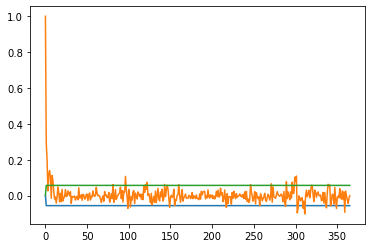

[ 0  1  2  3  4  5  6  8  9 10]


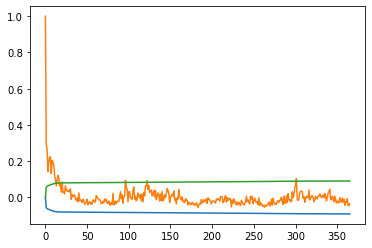

In [40]:
pacf_auto_corr, pacf_conf_int = pacf(data['log_diff_data'].dropna()**2, alpha=.05, nlags=365)
pacf_blue_area = pacf_conf_int - np.array([pacf_auto_corr,pacf_auto_corr]).T
neg_pacf_blue_area, pos_pacf_blue_area = pacf_blue_area.T
pacf_sig_lags = np.where(np.abs(pacf_auto_corr) > 2*np.abs(pos_pacf_blue_area[5]))[0]
pacf_usable_lags_binary = np.zeros(np.max(pacf_sig_lags)+1)
pacf_usable_lags_binary[significant_index] = 1
print(pacf_sig_lags)
plt.plot(neg_pacf_blue_area)
plt.plot(pacf_auto_corr)
plt.plot(pos_pacf_blue_area)
plt.show()

acf_auto_corr, acf_conf_int = acf(data['log_diff_data'].dropna()**2, alpha=.05, nlags=365, fft=True)
acf_blue_area = acf_conf_int - np.array([acf_auto_corr,acf_auto_corr]).T
neg_acf_blue_area, pos_acf_blue_area = acf_blue_area.T
acf_sig_lags = np.where(np.abs(acf_auto_corr) > 2*np.abs(pos_acf_blue_area[5]))[0]
acf_usable_lags_binary = np.zeros(np.max(acf_sig_lags)+1)
acf_usable_lags_binary[significant_index] = 1
print(acf_sig_lags)
plt.plot(neg_acf_blue_area)
plt.plot(acf_auto_corr)
plt.plot(pos_acf_blue_area)
plt.show()

In [24]:
significant_index

array([0, 1, 2, 4, 5], dtype=int64)

In [25]:
usable_lags_binary

array([1., 1., 1., 0., 1., 1.])

In [145]:
stats = pd.concat([model_fit.pvalues, model_fit.tvalues, pd.Series({'bic' : model_fit.bic}), pd.Series({'aic' : model_fit.aic})])

In [135]:
model_fit.bic, model_fit.aic

(5004.6500000555925, 4984.266427171202)

In [ ]:
differenciation de la série tant que pas stationnaire

In [25]:
train_df = data['log_diff_data'].loc[:"2022-05-31"]
test_df = data['log_diff_data'].loc["2022-06-01":]
test_df.shape, train_df.shape

((117,), (1091,))

In [34]:
data['log_diff_data'].mean()

0.0011117689513282338

In [ ]:
feature garch n+1

<ipython-input-26-6e1fdcd5fe4a>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(data['Close'],freq=365)


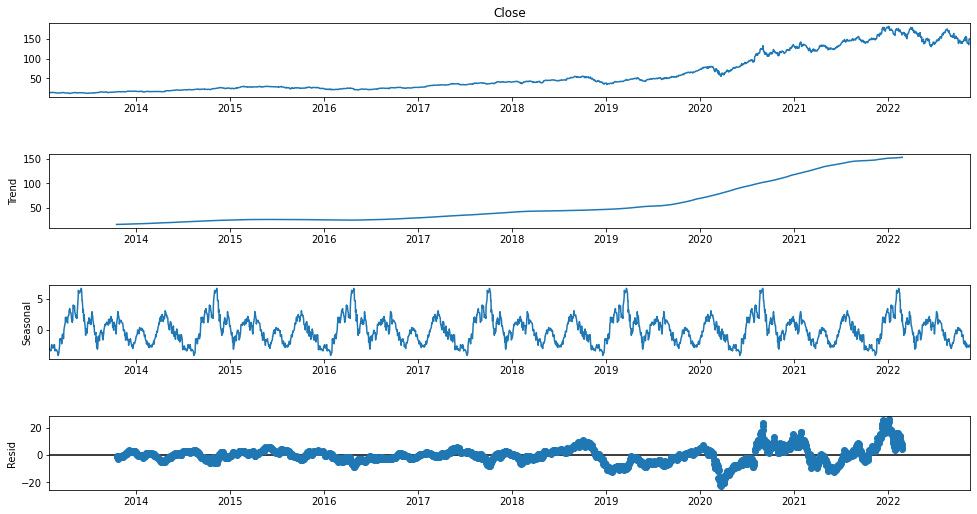

In [26]:
res = sm.tsa.seasonal_decompose(data['Close'],freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [29]:
corr_matrix = data.corr()
upperMatrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corrFeatures = [column for column in upperMatrix.columns if any(upperMatrix[column] > 0.90)]
corrFeatures

<ipython-input-29-ac1ba452f764>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upperMatrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['High',
 'Low',
 'Close',
 'volume_vwap',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'trend_macd_signal',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_diff',
 'trend_kst',
 'trend_kst_sig',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 'trend_ichimoku_b',
 'trend_cci',
 'trend_visual_ichimoku_a',
 'trend_visual_ichimoku_b',
 'trend_psar_up',
 'trend_psar_down',
 'momentum_rsi',
 'momentum_stoch_rsi_d',
 'momentum_stoch',
 'momentum_stoch_signal',
 'momentum_wr',
 'momentum_ao',
 'momentum_ppo',
 'momentum_ppo_signal',
 'momentum_kama',
 'others_dlr',
 'others_cr']

In [ ]:
data.isna().sum().max()

In [ ]:
series lagguées a ajouter (come prix j-1 prix j-2)
https://github.com/GoldinLocks/Cryptocurrency-Research-/blob/master/predicting-crypto-prices-with-deep-learning.ipynb
    https://www.srose.biz/wp-content/uploads/2020/08/Deep-Learning-Performance-Part-3-Batch-Normalization-Dropout-Noise.html
    garch s


In [ ]:
calmar

In [ ]:
estimer risk ajuster avec medaf + vol